# 纯股债风险平价组合

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
from scipy.optimize import minimize, basinhopping
import empyrical
%matplotlib inline

In [134]:
DATA_DIR = '../data/'
TOLERANCE = 1e-10

In [135]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret, risk_free=0.015/365)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(sharpe))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [136]:
fname = '%s/assets.xlsx'%(DATA_DIR)
odf = pd.read_excel(fname, index_col=0)

In [137]:
odf.tail()

,881001.WI,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE,B.IPE,H11025.CSI,CCFI.WI,CBA00401.CS,CBA02701.CS,000300.SH,000905.SH,000906.SH,000921.CSI,H00804.CSI
2019-03-21,4246.9516,29071.56,2854.88,189.4582,286.50,67.55,1519.8634,1067.2715,187.3158,176.3522,3836.8913,5589.4780,4129.8693,NaN,NaN
2019-03-22,4254.6575,29113.36,2800.71,189.5401,286.50,66.79,1519.9804,1072.9312,187.4811,176.3946,3833.8013,5622.1402,4133.4716,NaN,NaN
2019-03-25,4183.1487,28523.35,2798.36,189.7067,287.21,66.90,1520.3241,1060.3786,187.7665,176.5141,3742.8252,5549.6711,4046.7457,NaN,NaN
2019-03-26,4102.6560,28566.91,2818.46,189.7786,287.65,67.44,1520.4431,1060.6782,187.8270,176.5691,3700.4388,5394.8787,3983.7770,NaN,NaN
2019-03-27,4139.7307,28728.25,2805.37,189.7649,287.10,67.30,1520.5602,1061.6550,187.7983,176.6173,3743.3878,5447.8795,4028.2222,NaN,NaN


# 标准风险平价

In [138]:
def _allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]
    
    # It returns the risk of the weights distribution
    return portfolio_risk

In [139]:
def _assets_risk_contribution_to_allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)
    
    # calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) / portfolio_risk
    
    # It returns the contribution of each asset to the risk of the weights distribution
    return np.abs(assets_risk_contribution)

In [140]:
def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the weights distribution
    assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of each asset
    error = sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error

In [141]:
def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):
    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})
    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights

# 用样本协方差计算风险平价组合权重

In [142]:
df = odf[['000921.CSI', 'H00804.CSI', 'HSI.HI', 'SPX.GI', 'CBA00401.CS', 'CBA02701.CS']]

In [143]:
df = df.replace([0], np.NAN)

In [144]:
ret_df = df.pct_change().dropna()

### 过去一年协方差

In [145]:
covariances = ret_df.iloc[-242:].cov()

In [146]:
covariances*1e6

,000921.CSI,H00804.CSI,HSI.HI,SPX.GI,CBA00401.CS,CBA02701.CS
000921.CSI,192.499708,158.482497,120.728155,28.144286,-4.051541,-0.534682
H00804.CSI,158.482497,202.378667,100.250515,26.279032,-3.506015,-0.437402
HSI.HI,120.728155,100.250515,145.678441,31.552204,-2.707997,-0.233019
SPX.GI,28.144286,26.279032,31.552204,105.104407,-0.928692,0.010104
CBA00401.CS,-4.051541,-3.506015,-2.707997,-0.928692,1.355517,0.376005
CBA02701.CS,-0.534682,-0.437402,-0.233019,0.010104,0.376005,0.238637


In [147]:
empyrical.annual_volatility(ret_df['000921.CSI'])

0.2318476965844201

### 计算权重

In [148]:
n = df.shape[1]
init_weights = np.array([1. / n] * n)
assets_risk_budget = np.array([1./8, 1./8, 1./8, 1./8, 1./4, 1./4])
# assets_risk_budget = np.array([1. / n] * n)

In [149]:
assets_risk_budget

array([0.125, 0.125, 0.125, 0.125, 0.25 , 0.25 ])

### 等权下的风险贡献

In [150]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(init_weights), covariances.values)

In [151]:
rc

matrix([[2.09386941e-03],
        [2.04389267e-03],
        [1.67109422e-03],
        [8.03953971e-04],
        [4.00059935e-05],
        [2.45360204e-06]])

### 风险权重相等

In [152]:
weights = _get_risk_parity_weights(covariances.values*1e3, assets_risk_budget, init_weights)

In [153]:
weights

array([0.01360246, 0.01360257, 0.01547827, 0.02302656, 0.31408296,
       0.62020717])

In [154]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)

In [155]:
rc

matrix([[9.83160962e-05],
        [9.84231961e-05],
        [9.82089355e-05],
        [9.84350218e-05],
        [1.96739094e-04],
        [1.96675799e-04]])

In [156]:
(rc / rc.sum()).reshape(-1) - assets_risk_budget

matrix([[-4.27958257e-05,  9.33253739e-05, -1.78994328e-04,
          1.08355478e-04,  5.02779502e-05, -3.01686485e-05]])

In [157]:
abs((rc / rc.sum() - assets_risk_budget).sum()) < TOLERANCE

True

# 回测

In [158]:
new_df = df[(df.index >= ret_df.index[0]) & (df.index <= ret_df.index[-1])]

In [159]:
new_df.head()

,000921.CSI,H00804.CSI,HSI.HI,SPX.GI,CBA00401.CS,CBA02701.CS
2012-01-10,2265.152,5289.300,19004.28,1292.08,140.7523,120.3650
2012-01-11,2252.134,5261.511,19151.94,1292.48,140.6737,120.5957
2012-01-12,2253.985,5248.381,19095.38,1295.50,140.6691,120.7842
2012-01-13,2222.098,5098.562,19204.42,1289.09,140.6369,120.7946
2012-01-16,2194.519,4976.403,19012.20,1289.09,140.5895,120.8407


In [160]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
n, k = new_df.shape[1], 242
wb = np.zeros(n)
assets_risk_budget = np.array([1./8, 1./8, 1./8, 1./8, 1./4, 1./4])
init_weights = np.array([1. / n] * n)
for date in new_df.index:
    weight.loc[date] = wb
    if date.dayofweek == 4:
        past_return = ret_df[ret_df.index <= date][-k:]
        if past_return.shape[0] == k:
            covariances = past_return.cov()
            temp = wb.copy()
            wb = _get_risk_parity_weights(covariances.values*1e6, assets_risk_budget, init_weights)
            # check risk contribution
            rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)
            if abs((rc / rc.sum() - assets_risk_budget).sum()) > TOLERANCE:
                print(date)
                wb = temp.copy()

In [161]:
portfolio_ret = (weight * ret_df).sum(axis=1)
portfolio_ret = portfolio_ret[portfolio_ret != 0]

In [162]:
weight_plot = weight.drop_duplicates().iloc[1:].astype(np.float32)

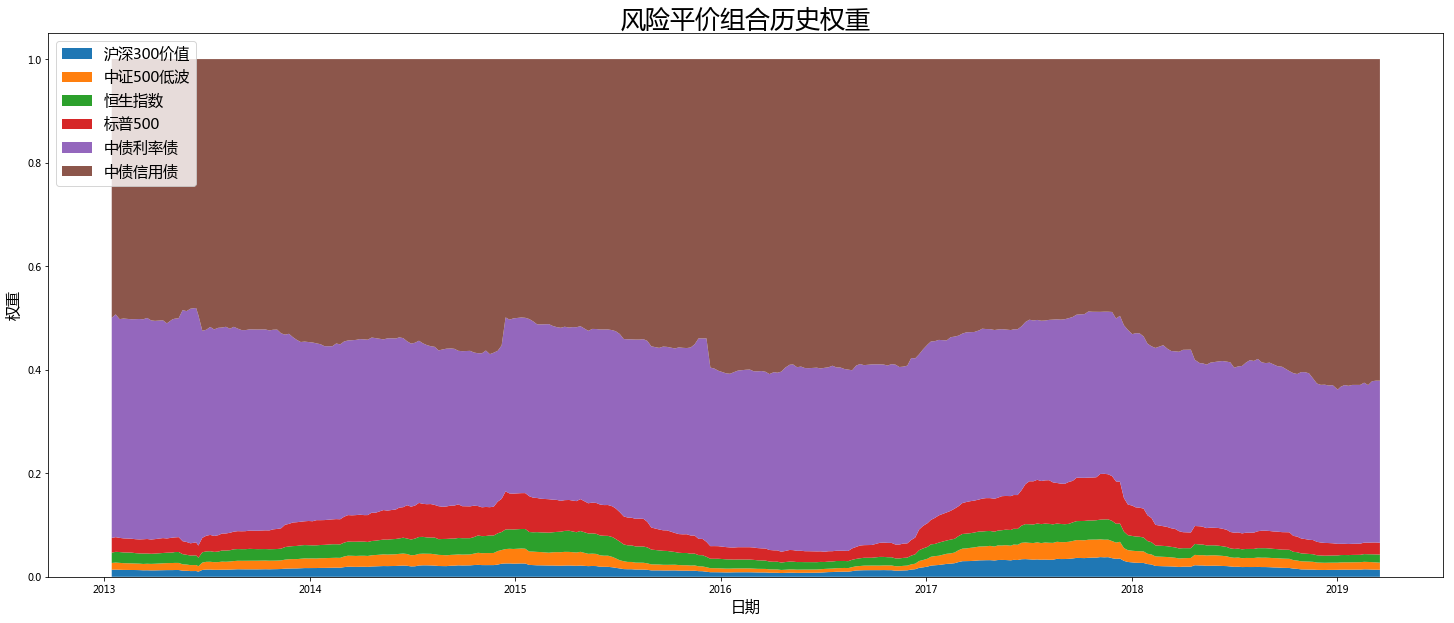

In [163]:
fig, ax = plt.subplots(figsize=(25, 10))
_ = ax.stackplot(weight_plot.index, 
                 weight_plot['000921.CSI'],
                 weight_plot['H00804.CSI'],
                 weight_plot['HSI.HI'],
                 weight_plot['SPX.GI'],
                 weight_plot['CBA00401.CS'], 
                 weight_plot['CBA02701.CS'],
                 labels=[u'沪深300价值', u'中证500低波', u'恒生指数', u'标普500', u'中债利率债', u'中债信用债'])
ax.legend(loc='upper left', fontsize=15)
ax.set_title(u'风险平价组合历史权重', fontsize=25)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
fig.savefig('../pic/stock-bond_portfolio_weight.jpg', dpi=200, bbox_inches='tight')

In [164]:
metric(portfolio_ret)

Annual return: 6.13%
Sharpe ratio: 2.73
Annual volatility: 1.81%
Max drawdown: -3.21%


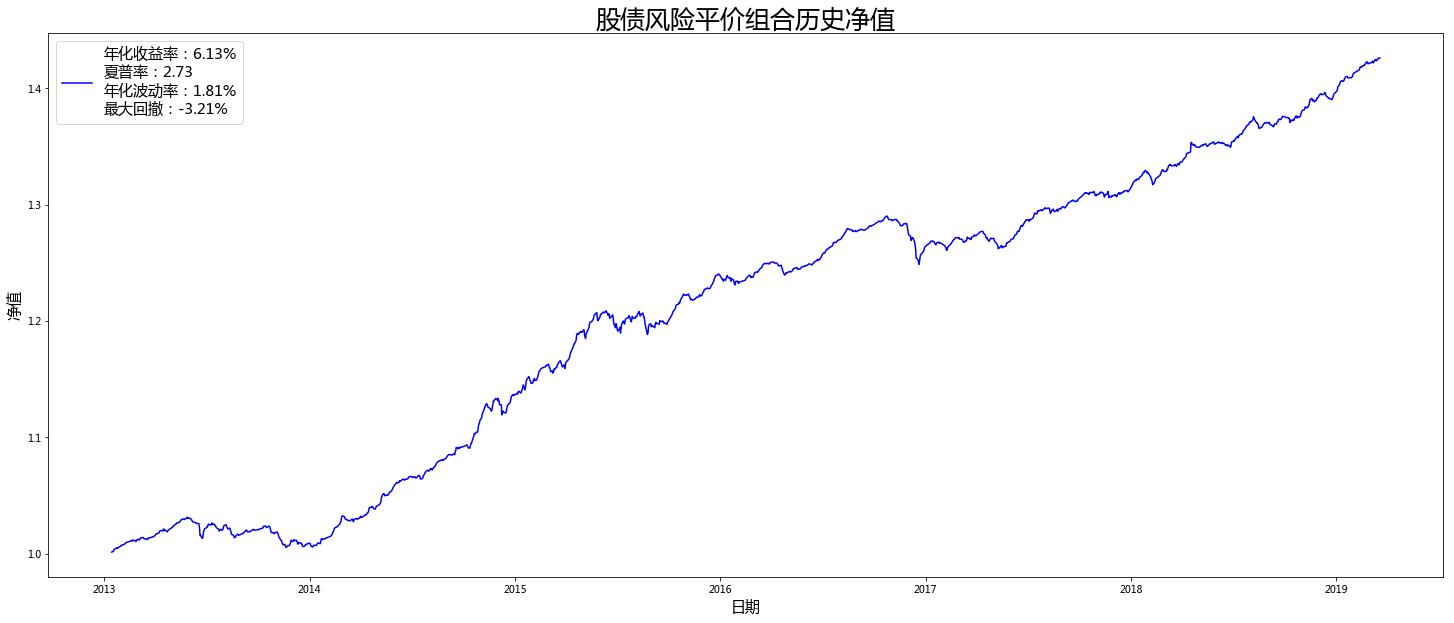

In [165]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot((1 + portfolio_ret).cumprod(), color='blue', 
        label=u'年化收益率：6.13%\n夏普率：2.73\n年化波动率：1.81%\n最大回撤：-3.21%')
ax.set_title(u'股债风险平价组合历史净值', fontsize=25)
ax.set_ylabel(u'净值', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
ax.legend(loc='upper left', fontsize=15)
fig.savefig('../pic/stock-bond_portfolio_return.jpg', dpi=200, bbox_inches='tight')

# 今年以来风险平价组合与各类资产情况

In [166]:
fname = u'../data/stock-bond_stats.xlsx'

In [167]:
workbook = xlsxwriter.Workbook(fname)
worksheet = workbook.add_worksheet()

In [168]:
col_format = workbook.add_format({'bold': True, 'align': 'center', 'font_name': u'楷体', 'font_color': '#FFFFFF', 'bg_color': '#993333'})
cell_format = workbook.add_format({'font_name': u'楷体'})
percent_format = workbook.add_format({'font_name': u'楷体', 'num_format': '0.00%'})
number_format = workbook.add_format({'font_name': u'楷体', 'num_format': '0.00'})

In [169]:
worksheet.write('A1', '', col_format)
worksheet.write('B1', u'收益率(周)', col_format)
worksheet.write('C1', u'收益率(月)', col_format)
worksheet.write('D1', u'收益率(年)', col_format)
worksheet.write('E1', u'波动率(年)', col_format)
worksheet.write('F1', u'夏普率(年)', col_format)
worksheet.write('G1', u'当前权重', col_format)
worksheet.write('H1', u'风险贡献', col_format)

0

In [170]:
weights = weight.iloc[-1]

In [171]:
worksheet.write('A2', u'沪深300价值', cell_format)
s = ret_df[ret_df.index >= '2019-01-01']['000921.CSI']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
w = weights['000921.CSI']
rc = assets_risk_budget[0]
worksheet.write('B2', retw, percent_format)
worksheet.write('C2', retm, percent_format)
worksheet.write('D2', ret, percent_format)
worksheet.write('E2', vol, percent_format)
worksheet.write('F2', sh, number_format)
worksheet.write('G2', w, percent_format)
worksheet.write('H2', rc, percent_format)

0

In [172]:
worksheet.write('A3', u'中证500低波', cell_format)
s = ret_df[ret_df.index >= '2019-01-01']['H00804.CSI']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
w = weights['H00804.CSI']
rc = assets_risk_budget[1]
worksheet.write('B3', retw, percent_format)
worksheet.write('C3', retm, percent_format)
worksheet.write('D3', ret, percent_format)
worksheet.write('E3', vol, percent_format)
worksheet.write('F3', sh, number_format)
worksheet.write('G3', w, percent_format)
worksheet.write('H3', rc, percent_format)

0

In [173]:
worksheet.write('A4', u'恒生指数', cell_format)
s = ret_df[ret_df.index >= '2019-01-01']['HSI.HI']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
w = weights['HSI.HI']
rc = assets_risk_budget[2]
worksheet.write('B4', retw, percent_format)
worksheet.write('C4', retm, percent_format)
worksheet.write('D4', ret, percent_format)
worksheet.write('E4', vol, percent_format)
worksheet.write('F4', sh, number_format)
worksheet.write('G4', w, percent_format)
worksheet.write('H4', rc, percent_format)

0

In [174]:
worksheet.write('A5', u'标普500', cell_format)
s = ret_df[ret_df.index >= '2019-01-01']['SPX.GI']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
w = weights['SPX.GI']
rc = assets_risk_budget[3]
worksheet.write('B5', retw, percent_format)
worksheet.write('C5', retm, percent_format)
worksheet.write('D5', ret, percent_format)
worksheet.write('E5', vol, percent_format)
worksheet.write('F5', sh, number_format)
worksheet.write('G5', w, percent_format)
worksheet.write('H5', rc, percent_format)

0

In [175]:
worksheet.write('A6', u'中债利率债', cell_format)
s = ret_df[ret_df.index >= '2019-01-01']['CBA00401.CS']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
w = weights['CBA00401.CS']
rc = assets_risk_budget[4]
worksheet.write('B6', retw, percent_format)
worksheet.write('C6', retm, percent_format)
worksheet.write('D6', ret, percent_format)
worksheet.write('E6', vol, percent_format)
worksheet.write('F6', sh, number_format)
worksheet.write('G6', w, percent_format)
worksheet.write('H6', rc, percent_format)

0

In [176]:
worksheet.write('A7', u'中债信用债', cell_format)
s = ret_df[ret_df.index >= '2019-01-01']['CBA02701.CS']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
w = weights['CBA02701.CS']
rc = assets_risk_budget[5]
worksheet.write('B7', retw, percent_format)
worksheet.write('C7', retm, percent_format)
worksheet.write('D7', ret, percent_format)
worksheet.write('E7', vol, percent_format)
worksheet.write('F7', sh, number_format)
worksheet.write('G7', w, percent_format)
worksheet.write('H7', rc, percent_format)

0

In [177]:
worksheet.write('A8', u'现金', cell_format)
s = odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change()
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = empyrical.cum_returns_final(s) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
worksheet.write('B8', retw, percent_format)
worksheet.write('C8', retm, percent_format)
worksheet.write('D8', ret, percent_format)
worksheet.write('E8', vol, percent_format)
worksheet.write('F8', sh, number_format)
worksheet.write('G8', 0, percent_format)
worksheet.write('H8', 0, percent_format)

0

In [178]:
worksheet.write('A9', u'风险平价组合', cell_format)
s = portfolio_ret[portfolio_ret.index >= '2019-01-01']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
worksheet.write('B9', retw, percent_format)
worksheet.write('C9', retm, percent_format)
worksheet.write('D9', ret, percent_format)
worksheet.write('E9', vol, percent_format)
worksheet.write('F9', sh, number_format)
worksheet.write('G9', 1, percent_format)
worksheet.write('H9', 1, percent_format)

0

In [179]:
worksheet.set_column(0, 0, 15)

0

In [180]:
workbook.close()